In [14]:
import jax
import jax.numpy as jnp
from jax.experimental import mesh_utils
import jax.scipy as jsp

from ott.data import get_cifar10
from ott.solvers.linear import sinkhorn
from ott.solvers import linear
from ott.geometry import pointcloud
from ott.geometry import costs
from ott.math import utils

from typing import Optional
import time
import matplotlib.pyplot as plt
import functools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import jax.scipy as jsp

In [16]:
x, y, label = get_cifar10(sigma=2, gaussian_blur_kernel_size=15, use_flip=True)
x.shape

  5%|▍         | 8126464/170498071 [00:03<01:18, 2078480.00it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


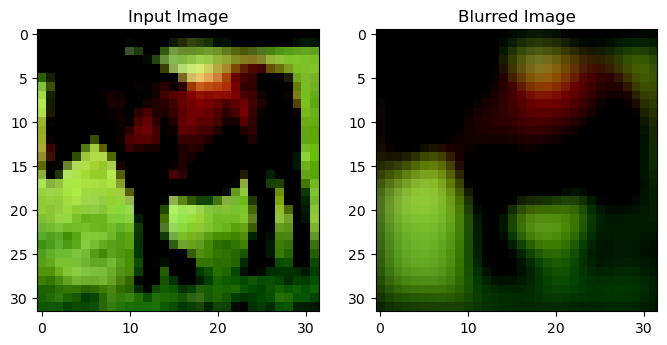

In [ ]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[7].reshape((3,32, 32)).transpose(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(y[7].reshape((3, 32, 32)).transpose(1, 2, 0))

In [13]:
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P

def shard_samples(x: jnp.ndarray) -> tuple[jnp.ndarray, NamedSharding]:
    num_devices = jax.device_count()
  
    devices = mesh_utils.create_device_mesh((num_devices,))
    mesh = Mesh(devices, axis_names=('batch',))
    sharding = NamedSharding(mesh, P('batch', None))
    
    return jax.device_put(x, sharding), sharding

In [ ]:
x_sharded, _ = shard_samples(x)
y_sharded, sharding = shard_samples(y)
# Sharding for x, y and epsilon
in_shardings = (sharding, sharding, None)


In [ ]:
@functools.partial(jax.jit, static_argnames=('batch_size',), in_shardings=in_shardings)
def run(x: jnp.ndarray, 
        y: jnp.ndarray, 
        epsilon: Optional[float] = None,
        batch_size: Optional[int]=None) -> sinkhorn.SinkhornOutput:
    geom = pointcloud.PointCloud(
        x, y, cost_fn=costs.Dotp(),
        batch_size=batch_size,
        epsilon=epsilon,
        relative_epsilon="std")
    return linear.solve(geom)



In [ ]:
n = x.shape[0]
kls = []
sums = []
times = []
epsilons = 10**jnp.linspace(-1.5, 1, 10)  # Epsilon values from 1 to 100
# Run the Sinkhorn solver with different epsilon values
for epsilon in epsilons:
    start = time.time()
    out = run(x_sharded, y_sharded, epsilon)
    assert out.converged, "Sinkhorn did not converge in {} iterations".format(out.n_iters)
    times.append(time.time() - start)
    diag = out.diag
    kls.append(utils.gen_kl(jnp.ones((n,))/n, diag))
    sums.append(jnp.sum(diag))
  

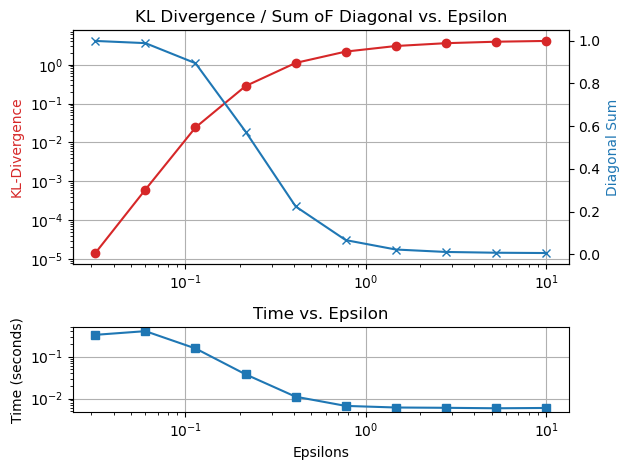

In [ ]:
ax_met = plt.subplot2grid((3, 1), (0,0), rowspan=2)
ax_times = plt.subplot2grid((3, 1), (2,0))
color = 'tab:red'
ax_met.set_ylabel('KL-Divergence', color=color)
ax_met.plot(epsilons, kls, color=color, marker='o')

ax2 = ax_met.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Diagonal Sum', color=color) 
ax2.plot(epsilons, sums, color=color, marker='x')
# ax2.tick_params(axis='y', labelcolor=color)
ax_met.set_xscale('log')
ax_met.set_yscale('log')
ax_met.set_title('KL Divergence / Sum oF Diagonal vs. Epsilon')
ax_met.grid(True)

ax_times.plot(epsilons,times, marker='s')
ax_times.set_xlabel('Epsilons')
ax_times.set_ylabel('Time (seconds)')
ax_times.set_xscale('log')
ax_times.set_yscale('log')
ax_times.set_title('Time vs. Epsilon')
ax_times.grid(True)
plt.tight_layout()